## Introduction


In this lab, you will learn how to leverage pre-trained models to build image classifiers instead of building a model from scratch.

## Import Libraries and Packages

Let's start the lab by importing the libraries that we will be using in this lab.

First, we will import the ImageDataGenerator module since we will be leveraging it to train our model in batches.

In [1]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In this lab, we will be using the Keras library to build an image classifier, so let's download the Keras library.

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Finally, we will be leveraging the ResNet50 model to build our classifier, so let's download it as well.

In [3]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import load_model

<a id='item32'></a>

## Download Data

For your convenience, I have placed the data on a server which you can retrieve easily using the **wget** command. So let's run the following line of code to get the data. Given the large size of the image dataset, it might take some time depending on your internet speed.

In [4]:
## get the data
#!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week3.zip

And now if you check the left directory pane, you should see the zipped file *concrete_data_week3.zip* appear. So, let's go ahead and unzip the file to access the images. Given the large number of images in the dataset, this might take a couple of minutes, so please be patient, and wait until the code finishes running.

In [5]:
#!unzip concrete_data_week3.zip

Now, you should see the folder *concrete_data_week3* appear in the left pane. If you open this folder by double-clicking on it, you will find that it contains two folders: *train* and *valid*. And if you explore these folders, you will find that each contains two subfolders: *positive* and *negative*. These are the same folders that we saw in the labs in the previous modules of this course, where *negative* is the negative class and it represents the concrete images with no cracks and *positive* is the positive class and it represents the concrete images with cracks.

**Important Note**: There are thousands and thousands of images in each folder, so please don't attempt to double click on the *negative* and *positive* folders. This may consume all of your memory and you may end up with a **50*** error. So please **DO NOT DO IT**.

<a id='item33'></a>

## Define Global Constants

Here, we will define constants that we will be using throughout the rest of the lab. 

1. We are obviously dealing with two classes, so *num_classes* is 2. 
2. The ResNet50 model was built and trained using images of size (224 x 224). Therefore, we will have to resize our images from (227 x 227) to (224 x 224).
3. We will training and validating the model using batches of 100 images.

In [6]:
num_classes = 2

image_resize = 224

batch_size_training = 100
batch_size_validation = 100

<a id='item34'></a>

## Construct ImageDataGenerator Instances

In order to instantiate an ImageDataGenerator instance, we will set the **preprocessing_function** argument to *preprocess_input* which we imported from **keras.applications.resnet50** in order to preprocess our images the same way the images used to train ResNet50 model were processed.

In [7]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

Next, we will use the *flow_from_directory* method to get the training images as follows:

In [8]:
train_generator = data_generator.flow_from_directory(
    'concrete_data_week3/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 30000 images belonging to 2 classes.


**Your Turn**: Use the *flow_from_directory* method to get the validation images and assign the result to **validation_generator**.

In [9]:
validation_generator = data_generator.flow_from_directory(
    'concrete_data_week3/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

Found 10000 images belonging to 2 classes.


Double-click __here__ for the solution.
<!-- The correct answer is:
validation_generator = data_generator.flow_from_directory(
    'concrete_data_week3/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')
-->



<a id='item35'></a>

## Build, Compile and Fit Model

In this section, we will start building our model. We will use the Sequential model class from Keras.

In [10]:
model = Sequential()

Next, we will add the ResNet50 pre-trained model to out model. However, note that we don't want to include the top layer or the output layer of the pre-trained model. We actually want to define our own output layer and train it so that it is optimized for our image dataset. In order to leave out the output layer of the pre-trained model, we will use the argument *include_top* and set it to **False**.

In [11]:
model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

Then, we will define our output layer as a **Dense** layer, that consists of two nodes and uses the **Softmax** function as the activation function.

In [12]:
model.add(Dense(num_classes, activation='softmax'))

You can access the model's layers using the *layers* attribute of our model object. 

In [13]:
model.layers

You can see that our model is composed of two sets of layers. The first set is the layers pertaining to ResNet50 and the second set is a single layer, which is our Dense layer that we defined above.

You can access the ResNet50 layers by running the following:

In [14]:
model.layers[0].layers

Since the ResNet50 model has already been trained, then we want to tell our model not to bother with training the ResNet part, but to train only our dense output layer. To do that, we run the following.

In [15]:
model.layers[0].trainable = False

And now using the *summary* attribute of the model, we can see how many parameters we will need to optimize in order to train the output layer.

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("resnet.h5",monitor='val_loss',verbose=1,save_best_only=True)

Next we compile our model using the **adam** optimizer.

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Before we are able to start the training process, with an ImageDataGenerator, we will need to define how many steps compose an epoch. Typically, that is the number of images divided by the batch size. Therefore, we define our steps per epoch as follows:

In [19]:
steps_per_epoch_training = len(train_generator)/60  #Added due to long training times
steps_per_epoch_validation = len(validation_generator)/20 #Added due to long training times
num_epochs = 5

Finally, we are ready to start training our model. Unlike a conventional deep learning training were data is not streamed from a directory, with an ImageDataGenerator where data is augmented in batches, we use the **fit_generator** method.

In [20]:
len(train_generator)

300

In [21]:
len(validation_generator)

100

In [22]:
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,callbacks=[checkpoint]
)

Epoch 1/5
5/5 [==============================] - 356s 71s/step - loss: 0.7061 - accuracy: 0.6020 - val_loss: 0.7312 - val_accuracy: 0.5380

Epoch 00001: val_loss improved from inf to 0.73122, saving model to resnet.h5
Epoch 2/5
5/5 [==============================] - 342s 68s/step - loss: 0.3303 - accuracy: 0.8960 - val_loss: 0.5651 - val_accuracy: 0.7400

Epoch 00002: val_loss improved from 0.73122 to 0.56515, saving model to resnet.h5
Epoch 3/5
5/5 [==============================] - 347s 69s/step - loss: 0.1762 - accuracy: 0.9600 - val_loss: 0.4095 - val_accuracy: 0.8540

Epoch 00003: val_loss improved from 0.56515 to 0.40945, saving model to resnet.h5
Epoch 4/5
5/5 [==============================] - 406s 81s/step - loss: 0.1054 - accuracy: 0.9780 - val_loss: 0.3799 - val_accuracy: 0.8160

Epoch 00004: val_loss improved from 0.40945 to 0.37993, saving model to resnet.h5
Epoch 5/5
5/5 [==============================] - 398s 80s/step - loss: 0.0846 - accuracy: 0.9800 - val_loss: 0.4073 

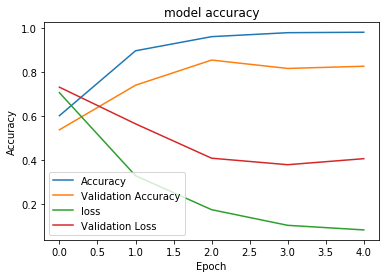

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
#Plot Graph to see the result
plt.plot(fit_history.history["accuracy"])
plt.plot(fit_history.history['val_accuracy'])
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

Now that the model is trained, you are ready to start using it to classify images.

Since training can take a long time when building deep learning models, it is always a good idea to save your model once the training is complete if you believe you will be using the model again later. You will be using this model in the next module, so go ahead and save your model.

In [ ]:
#model.save('classifier_resnet_model.h5')

### Load Resnet Model and Evaluate

In [28]:
resnet = model

In [29]:
resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [30]:
#Define directory

train_dir = r'C:\Users\Dennis\Desktop\AI Capstone Project with Deep Learning\concrete_data_week4\train'
validation_dir = r'C:\Users\Dennis\Desktop\AI Capstone Project with Deep Learning\concrete_data_week4\valid'
test_dir = r'C:\Users\Dennis\Desktop\AI Capstone Project with Deep Learning\concrete_data_week4\test'

In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size = (224,224),
            class_mode = 'categorical',
            batch_size = 100,
            shuffle=False)

Found 500 images belonging to 2 classes.


In [33]:
resloss = resnet.evaluate_generator(test_generator,steps=5,verbose=1)

5/5 [==============================] - 155s 31s/step


In [35]:
resloss

[2.75006103515625, 0.5]

In [37]:
print("Accuracy is %.2f%%" % (resloss[1]*100))

Accuracy is 50.00%


Now, you should see the model file *classifier_resnet_model.h5* apprear in the left directory pane.

### Thank you for completing this lab!

This notebook was created by Alex Aklson. I hope you found this lab interesting and educational.

This notebook is part of a course on **Coursera** called *AI Capstone Project with Deep Learning*. If you accessed this notebook outside the course, you can take this course online by clicking [here](https://cocl.us/DL0321EN_Coursera_Week3_LAB1).

<hr>

Copyright &copy; 2020 [IBM Developer Skills Network](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).